In [88]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from urllib.parse import urlparse
import re
import whois
import datetime
import requests

In [5]:
# This is main refrences to extract features from URLs
#https://towardsdatascience.com/phishing-domain-detection-with-ml-5be9c99293e5
#https://arxiv.org/pdf/2205.05121.pdf

## Data reading

- reading the CSV

In [45]:
df = pd.read_csv('malicious_phish.csv')
print('Shape of DataFrame:', df.shape)
print('Size of DataFrame:', df.size)
df_copy = df.copy()

Shape of DataFrame: (651191, 2)
Size of DataFrame: 1302382


- checking first five rows

In [46]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


- checking last five rows

In [47]:
df.tail()


,url,type
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing


## concise summary of our dataset

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


## Describing the Data

In [49]:
df.describe(exclude='number').T

,count,unique,top,freq
url,651191,641119,http://style.org.hc360.com/css/detail/mysite/s...,180
type,651191,4,benign,428103


## Checking for null values

In [50]:
df.isna().sum()

url     0
type    0
dtype: int64

## Checking if there are duplicates

In [51]:
df.duplicated().sum()

10066

In [52]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(651191, 2)
(641125, 2)


## Data Sampling

In [53]:
malware_data = df[df['type']=='malware'].head(2000)
benign_data = df[df['type']=='benign'].head(2000)
defacement_data = df[df['type']=='defacement'].head(2000)
phishing_data = df[df['type']=='phishing'].head(2000)

In [54]:
df = pd.concat([malware_data,benign_data,defacement_data,phishing_data]).reset_index()

In [55]:
df.drop('index',axis=1,inplace=True)

In [56]:
df.head()

,url,type
0,http://www.824555.com/app/member/SportOption.p...,malware
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware


## Data ploting

In [57]:
countTypes = df_copy.type.value_counts()
countTypes

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

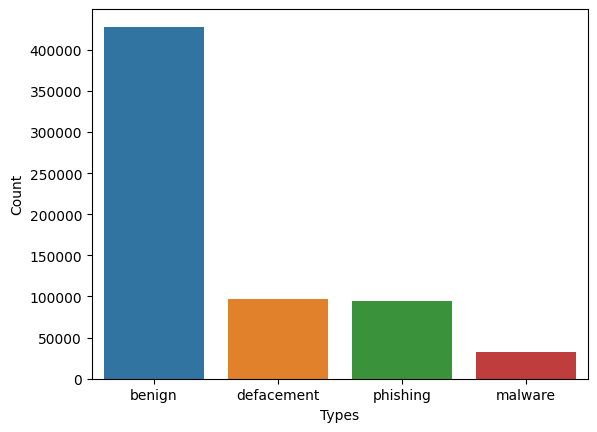

In [58]:
sns.barplot(x=countTypes.index, y=countTypes)
plt.xlabel('Types')
plt.ylabel('Count');

## Features Selection

In [59]:
def charCount(url, feature):
    return  url.count(feature)

In [60]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: charCount(i,a))

In [61]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1


In [62]:
#https://dmitripavlutin.com/parse-url-javascript/
#https://docs.python.org/3/library/re.html
# re.search : Scan through string looking for the
# first location where the regular expression pattern produces a match,
# and return a corresponding match object. Return None if 
# no position in the string matches the pattern; note that
# this is different from finding a zero-length match at some point in the string.

In [63]:
# check if the url has a hostname or not
def HasHostname(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0
    

In [64]:
df['HasHostname'] = df['url'].apply(lambda i: HasHostname(i))

In [65]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1


In [66]:
#https://python.readthedocs.io/en/v2.7.2/library/urlparse.html
# scheme return either http or https or None
# IsHttps to check if the url is https
def IsHttps(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [67]:
df['IsHttps'] = df['url'].apply(lambda i: IsHttps(i))

In [68]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0


In [69]:
# Count the number of digits in url (how many numbers there?)
def numberCount(url):
    numbers = 0
    for i in url:
        if i.isnumeric():
            numbers = numbers + 1
    return numbers

In [70]:
df['numberCount']= df['url'].apply(lambda i: numberCount(i))

In [71]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0,6
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0,22
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0,21
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0,30
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,8
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0,18


In [72]:
# Count the number of alphabets in url (how many letter there?)
def alphabetCount(url):
    alphabets = 0
    for i in url:
        if i.isalpha():
            alphabets = alphabets + 1
    return alphabets

In [73]:
df['alphabetCount']= df['url'].apply(lambda i: alphabetCount(i))

In [74]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0,6,48
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0,22,32
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0,21,21
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0,30,36
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0,17,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,8,47
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0,0,65
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0,18,161


In [75]:
# Check if the url conatins the short url (tinyURL)

def shortUrl(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [76]:
df['shortUrl'] = df['url'].apply(lambda x: shortUrl(x))

In [77]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0,6,48,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0,22,32,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0,21,21,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0,30,36,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0,17,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,8,47,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0,0,65,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0,18,161,0


In [78]:
# check if url contains IPv4 or IPv6
def ipAddress(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [79]:
df['ipAddress'] = df['url'].apply(lambda i: ipAddress(i))

In [80]:
df

,url,type,@,?,-,=,.,#,%,+,...,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,0,0,1,1,0,6,48,0,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,0,0,1,1,0,22,32,0,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,0,0,1,1,0,21,21,0,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,0,0,1,1,0,30,36,0,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,0,0,1,1,0,17,41,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,0,0,0,8,47,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,0,0,1,1,0,0,65,0,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,13,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,0,0,1,1,0,18,161,0,0


In [81]:
# https://pypi.org/project/python-whois/
# https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-python/ 
'''
To get domain age:
1- get domain name using whois and urlparse
2- If url has domain name ==> extract the creation and expiration dates ==> check if the age is more than 12

if age > 12 less phishing possibility  
else higher phishing possibility 
'''

'\nTo get domain age:\n1- get domain name using whois and urlparse\n2- If url has domain name ==> extract the creation and expiration dates ==> check if the age is more than 12\n\nif age > 12 less phishing possibility  \nelse higher phishing possibility \n\n'

In [82]:
def ageLess12Mon(url):
  try:
    domain_name = whois.whois(urlparse(url).netloc) 
    creation_date = domain_name.creation_date
    expiration_date = domain_name.expiration_date
    if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
      try:
        creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
        expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
      except:
        return 1
    if ((expiration_date is None) or (creation_date is None)):
        return 1
    else:
      ageofdomain = abs((expiration_date - creation_date).days)
      if ((ageofdomain/30) < 12):
        age = 1
      else:
        age = 0
  except:
      age = 1
 
  return age

In [83]:
df['ageLess12Mon'] = df['url'].apply(lambda i: ageLess12Mon(i))

In [84]:
df

,url,type,@,?,-,=,.,#,%,+,...,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,0,1,1,0,6,48,0,0,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,0,1,1,0,22,32,0,0,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,0,1,1,0,21,21,0,0,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,0,1,1,0,30,36,0,0,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,0,1,1,0,17,41,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,0,0,8,47,0,0,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,0,1,1,0,0,65,0,0,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,13,0,0,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,0,1,1,0,18,161,0,0,1


In [ ]:
'''
To get domain end:
1- get domain name using whois and urlparse
2- If url has domain name ==> extract the expiration date ==> check if the end is less than 6

if end > 6 less phishing possibility  
else higher phishing possibility 
'''

In [85]:
def endLess6Mon(url):
  try:
    domain_name = whois.whois(urlparse(url).netloc)
    expiration_date = domain_name.expiration_date
    if isinstance(expiration_date,str):
      try:
        expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
      except:
        return 1
    if (expiration_date is None):
        return 1
    else:
      today = datetime.now()
      end = abs((expiration_date - today).days)
      if ((end/30) < 6):
        end = 1
      else:
        end = 0
  except:
    end = 1

  return end

In [86]:
df['endLess6Mon'] = df['url'].apply(lambda i: endLess6Mon(i))

In [87]:
df

,url,type,@,?,-,=,.,#,%,+,...,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,1,1,0,6,48,0,0,1,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,1,1,0,22,32,0,0,1,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,1,1,0,21,21,0,0,1,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,1,1,0,30,36,0,0,1,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,1,1,0,17,41,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,0,8,47,0,0,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,1,1,0,0,65,0,0,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,0,13,0,0,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,1,1,0,18,161,0,0,1,1


In [ ]:
# phishing sites use iframe tags to create invisible links that users maybe click it
def hasIfram(url):
    try:
        response = requests.get(url)
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            return 0
        else:
            return 1
    except:
        return 1
    

In [91]:
df['hasIfram'] = df['url'].apply(lambda i: hasIfram(i))

In [ ]:
df

,url,type,@,?,-,=,.,#,%,+,...,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address,age,age2,end,Iframe
0,chat-by-orkut5.blogspot.it/,benign,0,0,2,0,2,0,0,0,...,0,0,1,21,0,0,1,1,1,1
1,yelp.com/biz/nowhere-new-york,benign,0,0,2,0,1,0,0,0,...,0,0,0,24,0,0,1,1,1,1
2,manta.com/c/mmn7bht/jon-barry-associates-inc,benign,0,0,3,0,1,0,0,0,...,0,0,1,36,0,0,1,1,1,1
3,formidable.typo3.ug/uploads/www.paypal.com.au/...,benign,0,1,3,5,6,0,0,0,...,0,0,53,211,0,0,1,1,1,1
4,http://www.rathgaelgym.org/info/club-policy,defacement,0,0,1,0,2,0,0,0,...,1,0,0,35,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,www.cheatcc.com/xb/azurik.html,phishing,0,0,0,0,3,0,0,0,...,0,0,0,25,0,0,1,1,1,1
96,answers.yahoo.com/question/index?qid=200802230...,benign,0,1,0,1,2,0,0,0,...,0,0,15,37,0,0,1,1,1,1
97,http://www.merlvic.com.au/index.php?option=com...,defacement,0,1,0,5,4,0,0,0,...,1,0,6,76,0,0,1,1,1,1
98,http://www.borg4x4.org/index.php?option=com_co...,defacement,0,1,0,5,3,0,0,0,...,1,0,5,68,0,0,0,0,1,0


In [ ]:
# https://www.google.com/url?sa=i&url=https%3A%2F%2Fsecurity.stackexchange.com%2Fquestions%2F41527%2Fis-the-web-browser-status-bar-always-trustable&psig=AOvVaw2cVoaiFrxGEx2u2o6La9e4&ust=1677095551544000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCKi81vaxp_0CFQAAAAAdAAAAABAD
# phishing sites use mouseover event from javascript to hide fake url
def hasMouseOver(url): 
  try:
    response = requests.get(url)
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0
  except:
        return 1

In [ ]:
df['hasMouseOver'] = df['url'].apply(lambda i: hasMouseOver(i))

In [ ]:
df

,url,type,@,?,-,=,.,#,%,+,...,https,digits,letters,Shortining_Service,having_ip_address,age,age2,end,Iframe,mouseOver
0,chat-by-orkut5.blogspot.it/,benign,0,0,2,0,2,0,0,0,...,0,1,21,0,0,1,1,1,1,1
1,yelp.com/biz/nowhere-new-york,benign,0,0,2,0,1,0,0,0,...,0,0,24,0,0,1,1,1,1,1
2,manta.com/c/mmn7bht/jon-barry-associates-inc,benign,0,0,3,0,1,0,0,0,...,0,1,36,0,0,1,1,1,1,1
3,formidable.typo3.ug/uploads/www.paypal.com.au/...,benign,0,1,3,5,6,0,0,0,...,0,53,211,0,0,1,1,1,1,1
4,http://www.rathgaelgym.org/info/club-policy,defacement,0,0,1,0,2,0,0,0,...,0,0,35,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,www.cheatcc.com/xb/azurik.html,phishing,0,0,0,0,3,0,0,0,...,0,0,25,0,0,1,1,1,1,1
96,answers.yahoo.com/question/index?qid=200802230...,benign,0,1,0,1,2,0,0,0,...,0,15,37,0,0,1,1,1,1,1
97,http://www.merlvic.com.au/index.php?option=com...,defacement,0,1,0,5,4,0,0,0,...,0,6,76,0,0,1,1,1,1,1
98,http://www.borg4x4.org/index.php?option=com_co...,defacement,0,1,0,5,3,0,0,0,...,0,5,68,0,0,0,0,1,0,0


In [110]:
# This part explained in the paper, disabled the right click option so the user cann't incpect the webpage
def disabledRightClick(url): 
  try:
    response = requests.get(url)
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1
  except:
        return 1

In [111]:
df['disabledRightClick'] = df['url'].apply(lambda i: disabledRightClick(i))

In [112]:
df

,url,type,@,?,-,=,.,#,%,+,...,digits,letters,Shortining_Service,having_ip_address,age,age2,end,Iframe,mouseOver,rightClick
0,chat-by-orkut5.blogspot.it/,benign,0,0,2,0,2,0,0,0,...,1,21,0,0,1,1,1,1,1,1
1,yelp.com/biz/nowhere-new-york,benign,0,0,2,0,1,0,0,0,...,0,24,0,0,1,1,1,1,1,1
2,manta.com/c/mmn7bht/jon-barry-associates-inc,benign,0,0,3,0,1,0,0,0,...,1,36,0,0,1,1,1,1,1,1
3,formidable.typo3.ug/uploads/www.paypal.com.au/...,benign,0,1,3,5,6,0,0,0,...,53,211,0,0,1,1,1,1,1,1
4,http://www.rathgaelgym.org/info/club-policy,defacement,0,0,1,0,2,0,0,0,...,0,35,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,www.cheatcc.com/xb/azurik.html,phishing,0,0,0,0,3,0,0,0,...,0,25,0,0,1,1,1,1,1,1
96,answers.yahoo.com/question/index?qid=200802230...,benign,0,1,0,1,2,0,0,0,...,15,37,0,0,1,1,1,1,1,1
97,http://www.merlvic.com.au/index.php?option=com...,defacement,0,1,0,5,4,0,0,0,...,6,76,0,0,1,1,1,1,1,1
98,http://www.borg4x4.org/index.php?option=com_co...,defacement,0,1,0,5,3,0,0,0,...,5,68,0,0,0,0,1,0,0,1


In [114]:
# This part explained in the paper, multiple redirect webpages have a high possibility to be a phising websits
def isMultiDirected(url): 
  try:
    response = requests.get(url)
    if len(response.history) <= 2:
      return 0
    else:
      return 1
  except:
        return 1

In [115]:
df['isMultiDirected'] = df['url'].apply(lambda i: isMultiDirected(i))

In [ ]:
df